In [ ]:
# function ClickConnect(){
#     console.log("런타임 끊김 방지"); 
#     document.querySelector("colab-toolbar-button#connect").click() 
# }
# setInterval(ClickConnect, 60 * 1000)

In [1]:

from google.colab import drive
drive.mount('/content/drive')

folder = '/content/drive/MyDrive/Colab Notebooks/1s'


Mounted at /content/drive


In [2]:
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install xgboost
# !pip install lightgbm
# !pip install sklearn
# !pip install graphviz

# 라이브러리 임포트
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn

# EDA

In [3]:
# df = pd.read_csv('/content/drive/MyDrive/train.csv')
df = pd.read_csv(os.path.join(folder, 'train.csv'))
df.head(20)

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
0,0.0824,21000.00,29.19,0,1,0,3016,26,0,0,0,11773,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1200,1200.0,0.0,1,18,37.74,0.076,0.0,0.0,157.94,765,769,0
1,0.1299,80000.00,4.82,0,1,1,5722,24,0,0,0,21875,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,8,269.52,0.447,0.0,0.0,1702.42,665,669,0
2,0.1299,38000.00,23.66,0,3,0,6511,18,0,0,0,31868,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5000,5000.0,0.0,1,7,168.45,0.880,0.0,0.0,1066.64,670,674,0
3,0.1367,100000.00,16.27,4,2,0,6849,30,0,0,0,326049,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,15000,15000.0,0.0,1,12,510.27,0.457,0.0,0.0,1256.24,680,684,1
4,0.1269,30000.00,25.28,0,1,2,8197,12,0,0,2506,8840,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,10000,10000.0,0.0,1,8,335.45,0.416,0.0,0.0,871.04,660,664,1
5,0.1318,90000.00,3.48,7,0,0,2903,31,0,0,0,19548,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,7000,7000.0,0.0,1,7,236.47,0.854,0.0,0.0,1330.30,660,664,0
6,0.0791,60000.00,17.34,0,0,0,20399,35,0,0,0,117320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,20000,20000.0,0.0,1,18,625.90,0.369,0.0,0.0,2567.44,750,754,0
7,0.0975,79600.00,15.97,3,0,1,6481,17,0,0,0,18757,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,23800,23800.0,0.0,1,7,765.17,0.745,0.0,0.0,3006.76,680,684,0
8,0.0789,150000.00,7.36,1,0,0,15827,38,0,0,543,367504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,16000,16000.0,0.0,1,19,500.58,0.334,0.0,0.0,1286.38,665,669,0
9,0.0999,95000.00,25.78,0,1,0,17870,37,0,0,0,273776,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,24,258.10,0.764,0.0,0.0,796.59,665,669,0


# EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   int_rate                    100000 non-null  float64
 1   annual_inc                  100000 non-null  float64
 2   dti                         100000 non-null  float64
 3   delinq_2yrs                 100000 non-null  int64  
 4   inq_last_6mths              100000 non-null  int64  
 5   pub_rec                     100000 non-null  int64  
 6   revol_bal                   100000 non-null  int64  
 7   total_acc                   100000 non-null  int64  
 8   collections_12_mths_ex_med  100000 non-null  int64  
 9   acc_now_delinq              100000 non-null  int64  
 10  tot_coll_amt                100000 non-null  int64  
 11  tot_cur_bal                 100000 non-null  int64  
 12  chargeoff_within_12_mths    100000 non-null  int64  
 13  delinq_amnt    

In [5]:
df.describe()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
count,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.130833,7.436061e+04,18.514508,0.343700,0.668880,0.235720,16090.202820,24.675910,0.018810,0.005800,250.588120,1.305281e+05,0.009630,19.288330,0.063820,0.065400,0.326240,0.089410,0.08058,0.059480,0.060710,0.046640,0.045320,0.045690,0.038570,0.075550,0.066410,0.000330,0.466120,0.000070,0.000050,0.110880,0.422550,0.321800,0.390200,0.288000,0.009620,0.226720,0.582810,0.0,0.060400,0.004250,0.019830,0.01101,0.007310,0.058200,0.000650,0.011250,0.007070,0.000880,0.434430,0.565570,0.489320,0.052360,0.060090,0.045700,0.050750,0.048560,0.051340,0.053430,0.048960,0.050030,0.049460,13735.317750,13729.341073,2.448885e+00,0.855920,11.620700,434.077648,0.537233,0.253327,0.253259,2491.282802,692.630550,696.630660,0.325690
std,0.044773,7.467409e+04,8.413049,0.905007,0.952044,0.661468,21569.939271,11.883834,0.150321,0.083585,2042.770881,1.503326e+05,0.110079,893.304366,0.468027,0.247232,0.468839,0.285336,0.27219,0.236522,0.238799,0.210868,0.208006,0.208813,0.192569,0.264278,0.248999,0.018163,0.498853,0.008366,0.007071,0.313985,0.493968,0.467169,0.487797,0.452833,0.097609,0.418712,0.493097,0.0,0.238228,0.065054,0.139417,0.10435,0.085186,0.234122,0.025487,0.105468,0.083786,0.029652,0.495684,0.495684,0.499888,0.222753,0.237655,0.208835,0.219488,0.214947,0.220691,0.224891,0.215786,0.218008,0.216828,8464.825314,8461.694483,1.489496e+01,0.351173,5.458774,265.921746,0.239373,18.053290,18.051746,2706.262200,29.668017,29.668584,0.468634
min,0.053200,5.360000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,

# Train Valid Split

In [6]:
X = df.drop('depvar', axis=1)
y = df['depvar']

In [7]:
# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
# X_test, X_valid, y_test, y_valid = train_test_split(X_valid, y_valid, test_size=0.5)


In [8]:
# training set과 validation set의 데이터 수 확인
print('training set length :', len(X_train))
print('validation set length :', len(X_valid))
# print('test set length :', len(X_test))

training set length : 80000
validation set length : 20000


In [9]:
# validation set의 라벨 비율 확인
print(y_valid.sum()/len(y_valid))
# print(y_test.sum()/len(y_test))


0.32965


In [10]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도accuracy: {:.4f}'.format(accuracy))
    print('정밀도precision: {:.4f}'.format(precision))
    print('재현율recall: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')
    return {'정확도accuracy' : accuracy, '정밀도precision': precision, '재현율recall': recall, 'AUC': AUC, 'F1': F1}

# TabNet    
https://wsshin.tistory.com/5   
https://dreamquark-ai.github.io/tabnet/generated_docs/README.html#tabnet-attentive-interpretable-tabular-learning   
https://github.com/dreamquark-ai/tabnet

In [11]:
!pip install pytorch-tabnet

In [12]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor


#catboost   
https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_fit

In [13]:
!pip install catboost
from catboost import CatBoostClassifier, Pool, CatBoostRegressor

     |████████████████████████████████| 76.1 MB 42 kB/s 


# Ensemble(Voting)

In [14]:
rnd_clf = RandomForestClassifier()
lgbm_clf = LGBMClassifier()
xgb_clf = xgboost.XGBClassifier()

rid_clf = RidgeClassifier()
dtc_clf = DecisionTreeClassifier()
svm_clf = SVC()
ada_clf = AdaBoostClassifier()
gbc_clf = GradientBoostingClassifier()
bag_clf = BaggingClassifier()
ext_clf = ExtraTreesClassifier()
knn_clf = KNeighborsClassifier()


# tabnet_clf = TabNetClassifier()
cat_clf = CatBoostClassifier()

In [15]:


# voting_clf = VotingClassifier(estimators=[('tab',tabnet_clf),('cat',cat_clf),('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf),
#                                           ('rid', rid_clf), ('dtc', dtc_clf), ('svm', svm_clf), ('ada', ada_clf), ('gbc', gbc_clf), ('bag', bag_clf), ('ext', ext_clf), ('knn', knn_clf),  voting='soft')

In [16]:
!pip install scikit-optimize

     |████████████████████████████████| 100 kB 3.2 MB/s 


In [17]:
from skopt import BayesSearchCV
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [18]:
result = []

# rnd_clf = RandomForestClassifier()_bayesopt

In [19]:

# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

90


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=7, n_estimators=400;, score=0.706 total time=  50.1s
[CV 2/5] END criterion=entropy, max_depth=7, n_estimators=400;, score=0.705 total time=  34.4s
[CV 3/5] END criterion=entropy, max_depth=7, n_estimators=400;, score=0.703 total time=  34.6s
[CV 4/5] END criterion=entropy, max_depth=7, n_estimators=400;, score=0.702 total time=  35.8s
[CV 5/5] END criterion=entropy, max_depth=7, n_estimators=400;, score=0.703 total time=  34.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=8, n_estimators=200;, score=0.710 total time=  16.5s
[CV 2/5] END criterion=gini, max_depth=8, n_estimators=200;, score=0.710 total time=  21.6s
[CV 3/5] END criterion=gini, max_depth=8, n_estimators=200;, score=0.710 total time=  17.1s
[CV 4/5] END criterion=gini, max_depth=8, n_estimators=200;, score=0.708 total time=  16.6s
[CV 5/5] END criterion=gini, max_depth=

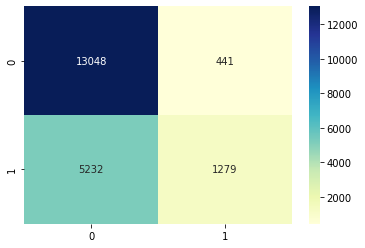

In [20]:
# log-uniform: understand as search over p = exp(x) by varying x
# opt_rnd_clf = BayesSearchCV(
#     rnd_clf,
#     params = {
#     "n_estimators": [100, 200, 300, 400],
#     "max_depth": (1, 9),
#     "criterion": ["gini", "entropy"],
#     },
#     optimizer_kwargs={'base_estimator': 'RF'},
#     n_iter=32,
#     cv=3
# )
opt_rnd_clf = BayesSearchCV(
    estimator=rnd_clf,
    search_spaces={
    "n_estimators": [100, 200, 300, 400],
    "max_depth": (1, 9),
    "criterion": ["gini", "entropy"],
},
    n_jobs=1,
    cv=5,
    n_iter=30,
    scoring="accuracy",
    verbose=4,
    random_state=42
)

print(opt_rnd_clf.total_iterations)

opt_rnd_clf.get_params().keys()

opt_rnd_clf.fit(X_train, y_train)
y_pred_opt = opt_rnd_clf.predict(X_valid)

r = get_clf_eval(y_valid, y_pred_opt)
print(r)
result.append(('opt_rnd_clf',r))

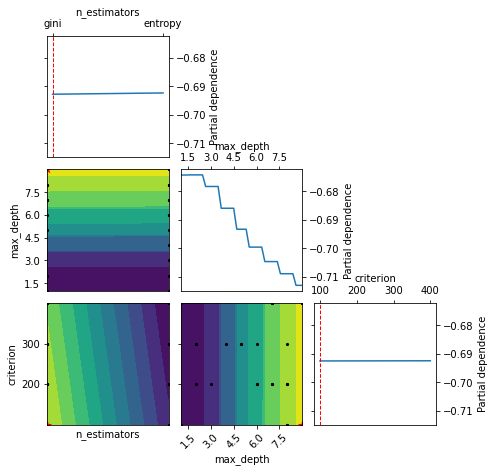

In [21]:
from skopt.plots import plot_objective, plot_histogram
_ = plot_objective(opt_rnd_clf.optimizer_results_[0],
                   dimensions=["n_estimators", "max_depth", "criterion"],
                   n_minimum_search=int(1e8))
plt.show()

# lgbm_clf = LGBMClassifier()_bayesopt

In [46]:
searchcv = BayesSearchCV(
    ('lgbm', lgbm_clf),
    search_spaces=[
        ({'C': (0.1, 1.0)}, 19),  # 19 iterations for this subspace
        {'gamma':(0.1, 1.0)}
    ],
    n_iter=23
)

print(searchcv.total_iterations)

42



정확도accuracy: 0.7507
정밀도precision: 0.6598
재현율recall: 0.4840
AUC: 0.6817
F1: 0.5584
{'정확도accuracy': 0.7507, '정밀도precision': 0.6598283441490476, '재현율recall': 0.4839551665898971, 'AUC': 0.6817343861421348, 'F1': 0.55837023914969}


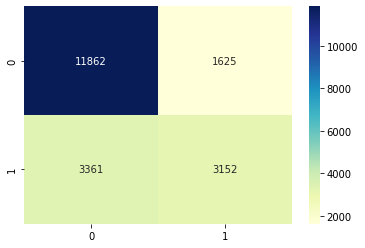

In [47]:
# log-uniform: understand as search over p = exp(x) by varying x
opt_lgbm_clf = BayesSearchCV(
    lgbm_clf,
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt_lgbm_clf.fit(X_train, y_train)
y_pred_opt = opt_lgbm_clf.predict(X_valid)

r = get_clf_eval(y_valid, y_pred_opt)
print(r)
result.append(('opt_lgbm_clf',r))

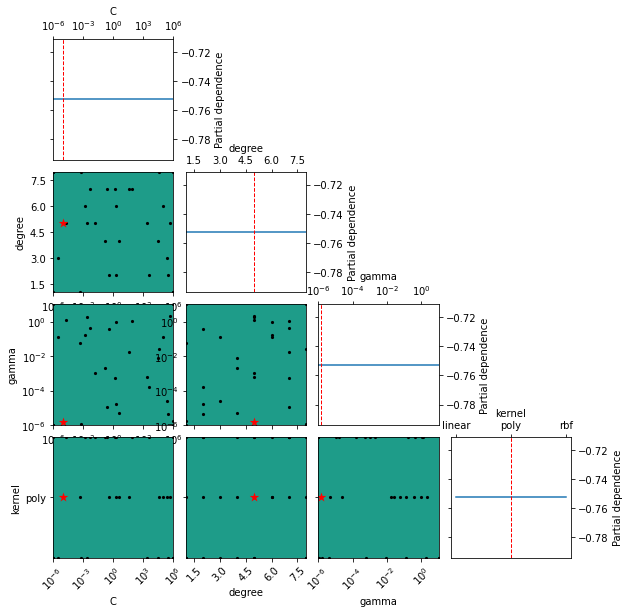

In [48]:
from skopt.plots import plot_objective, plot_histogram
_ = plot_objective(opt_lgbm_clf.optimizer_results_[0],
                   dimensions=["C", "degree", "gamma", "kernel"],
                   n_minimum_search=int(1e8))
plt.show()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from skopt import BayesSearchCV

In [ ]:
bayes_cv_tuner = BayesSearchCV( estimator = lgb.LGBMClassifier(boosting_type='gbdt', n_jobs=-1, verbose=2),
        search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'num_leaves': (2, 500),
        'max_depth': (0, 500),
        'min_child_samples': (0, 200),
        'max_bin': (100, 100000),
        'subsample': (0.01, 1.0, 'uniform'),
        'subsample_freq': (0, 10),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'min_child_weight': (0, 10),
        'subsample_for_bin': (100000, 500000),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'scale_pos_weight': (1e-6, 500, 'log-uniform'),
        'n_estimators': (10, 10000),
        },
        scoring = 'f1_macro', cv = StratifiedKFold(n_splits=2), n_iter = 30, verbose = 1, refit = True)

In [ ]:
def rfecv_opt(model, n_jobs, X, y, cv = StratifiedKFold(2)):
    rfecv = RFECV(estimator = model, step = 1, cv = cv,
                    n_jobs = n_jobs, scoring = 'f1_macro', verbose = 1)
    rfecv.fit(X.values, y.values.ravel())
    print('Optimal number of features : %d', rfecv.n_features_)
    print('Max score with current model :', round(np.max(rfecv.grid_scores_), 3))
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel('Number of features selected')
    plt.ylabel('Cross validation score (f1_macro)')
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    important_columns = []
    n = 0
    for i in rfecv.support_:
        if i == True:
            important_columns.append(X.columns[n])
        n +=1
    return important_columns, np.max(rfecv.grid_scores_), rfecv

In [ ]:
def routine(X, y, n_iter_max, n_jobs):
    list_models = []
    list_scores_max = []
    list_features = []
    list_f1_score = []
    for i in range(n_iter_max):
        print('Currently on iteration', i+1, 'of', n_iter_max, '.')
        if i == 0:
            model = lgb.LGBMClassifier(max_depth=-1, learning_rate=0.1, objective='multiclass',
                            silent = True, metric = 'None', n_jobs = n_jobs,
                            n_estimators = 8000, class_weight = 'balanced')
        else:
            print('Adjusting model.')
            X_provi = X[imp_columns]
            # Get current parameters and the best parameters    
            result = bayes_cv_tuner.fit(X_provi.values, y.values.ravel())
            best_params = pd.Series(result.best_params_)
            param_dict=pd.Series.to_dict(best_params)
            model = lgb.LGBMClassifier(colsample_bytree = param_dict['colsample_bytree'],
                          learning_rate = param_dict['learning_rate'],
                          max_bin = int(param_dict['max_bin']),
                          max_depth = int(param_dict['max_depth']),
                          min_child_samples = int(param_dict['min_child_samples']),
                          min_child_weight = param_dict['min_child_weight'],
                          n_estimators = int(param_dict['n_estimators']),
                          num_leaves = int(param_dict['num_leaves']),
                          reg_alpha = param_dict['reg_alpha'],
                          reg_lambda = param_dict['reg_lambda'],
                          scale_pos_weight = param_dict['scale_pos_weight'],
                          subsample = param_dict['subsample'],
                          subsample_for_bin = int(param_dict['subsample_for_bin']),
                          subsample_freq = int(param_dict['subsample_freq']),
                          n_jobs = n_jobs,
                          class_weight='balanced',
                          objective='multiclass'
                          )
        imp_columns, max_score, rfecv = rfecv_opt(model, n_jobs, X, y)
        list_models.append(model)
        list_scores_max.append(max_score)
        list_features.append(imp_columns)
        
    return list_models, list_scores_max, list_features

In [ ]:
list_models, list_scores_max, list_features = routine(X, y, 15, 4)

index_max = list_scores_max.index(max(list_scores_max))
features = list_features[index_max]
model = list_models[index_max]

In [ ]:
columnlist=[]
for col in X_train.columns:
    columnlist.append(col)
print(columnlist)

In [ ]:
model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.364429092365, learning_rate=0.11718910536,
        max_bin=75490, max_depth=312, min_child_samples=21,
        min_child_weight=7.0, min_split_gain=0.0, n_estimators=5392,
        n_jobs=15, num_leaves=249, objective='multiclass',
        random_state=None, reg_alpha=2.51960359296e-05,
        reg_lambda=10.9020792516, scale_pos_weight=0.0247756521295,
        silent=True, subsample=0.195224406679, subsample_for_bin=126252,
        subsample_freq=3)

features = columnlist

In [ ]:
test_model = model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=500, verbose=200)

In [ ]:
predictions = test_model.predict(X_test)

print('F1-macro score on train = ', f1_score(y_test, predictions, average='macro'))

In [ ]:
from bayes_opt import BayesianOptimization

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def lgb_f1_score(y_hat, data):
    y_true = data.get_label().astype(int)
    y_hat = np.round(y_hat).astype(int) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat, average='weighted'), True


n_folds = 5
random_seed=6

def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
    params = {'application':'binary',
              'num_iterations': 500 , 
              'learning_rate':0.05, 
              'early_stopping_round':100,
              "objective" : "binary",
              "num_threads" : 20 ,
             }
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    cv_result = lgb.cv(params, d_train,
                       nfold=n_folds, seed=random_seed, 
                       stratified=True, verbose_eval =200, 
                       metrics=["None"], 
                       feval=lgb_f1_score
                      )
    return max(cv_result['f1-mean'])
lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.8, 1),
                                        'max_depth': (5, 8.99),
                                        'lambda_l1': (0, 5),
                                        'lambda_l2': (0, 3),
                                        'min_split_gain': (0.001, 0.1),
                                        'min_child_weight': (5, 50)}, random_state=0)
init_round=5
opt_round = 10
lgbBO.maximize(init_points=init_round, n_iter=opt_round)
lgbBO.points_to_csv("lgb_bayes_opt_result.csv")
params = lgbBO.res['max']['max_params']
lgb2 = lgb.train(params, d_train , 100)
#lgb2 = lgb.train(params, d_train, 100)
lgb_prob = lgb2.predict( lgb_test.values )

## 변수 중요도 시각화 
lgb.plot_importance(lgb2)
plt.show()
feature_importance = pd.DataFrame([lgb2.feature_name() , lgb2.feature_importance()]).T
feature_importance.columns = ["feature", "varimp"]
feature_importance = feature_importance.sort_values(["varimp"], ascending = False)
sns.barplot(y="feature", x="varimp",data = feature_importance)
plt.show()

# xgb_clf = xgboost.XGBClassifier()_bayesopt

In [ ]:

# define models and parameters
model = GradientBoostingClassifier()
n_estimators = [10, 100, 1000]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]
# define grid search
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
y_pred_opt = grid_search.predict(X_valid)

r = get_clf_eval(y_valid, y_pred_opt)
print(r)
result.append(('grid_search_xgb',r))


정확도accuracy: 0.7356
정밀도precision: 0.6821
재현율recall: 0.3519
AUC: 0.6364
F1: 0.4643
{'정확도accuracy': 0.73555, '정밀도precision': 0.6821428571428572, '재현율recall': 0.3519115614923998, 'AUC': 0.6363620979405352, 'F1': 0.4642965663931936}


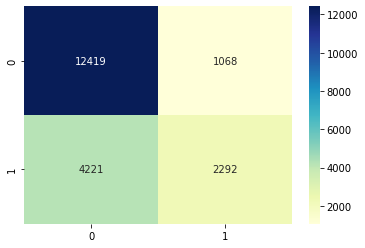

In [50]:
searchcv = BayesSearchCV(
    ('xgb', xgb_clf),
    search_spaces=[
        ({'C': (0.1, 1.0)}, 19),  # 19 iterations for this subspace
        {'gamma':(0.1, 1.0)}
    ],
    n_iter=23
)

print(searchcv.total_iterations)

# log-uniform: understand as search over p = exp(x) by varying x
opt_xgb_clf = BayesSearchCV(
    xgb_clf,
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt_xgb_clf.fit(X_train, y_train)
y_pred_opt = opt_xgb_clf.predict(X_valid)

r = get_clf_eval(y_valid, y_pred_opt)
print(r)
result.append(('opt_xgb_clf',r))

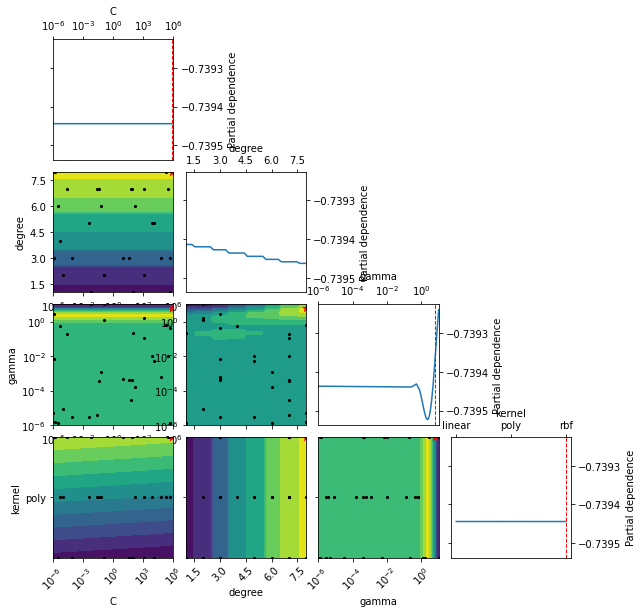

In [51]:
from skopt.plots import plot_objective, plot_histogram
_ = plot_objective(opt_xgb_clf.optimizer_results_[0],
                   dimensions=["C", "degree", "gamma", "kernel"],
                   n_minimum_search=int(1e8))
plt.show()

# rid_clf = RidgeClassifier()_bayesopt

In [52]:

model = RidgeClassifier()
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# define grid search
grid = dict(alpha=alpha)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

42


In [53]:
searchcv = BayesSearchCV(
    ('rid', rid_clf),
    search_spaces=[
        ({'C': (0.1, 1.0)}, 19),  # 19 iterations for this subspace
        {'gamma':(0.1, 1.0)}
    ],
    n_iter=23
)

print(searchcv.total_iterations)
# log-uniform: understand as search over p = exp(x) by varying x
opt_rid_clf = BayesSearchCV(
    rid_clf,
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt_rid_clf.fit(X_train, y_train)
y_pred_opt = opt_rid_clf.predict(X_valid)

r = get_clf_eval(y_valid, y_pred_opt)
print(r)
result.append(('opt_rid_clf',r))

ValueError: ignored

In [ ]:
from skopt.plots import plot_objective, plot_histogram
_ = plot_objective(opt_rid_clf.optimizer_results_[0],
                   dimensions=["C", "degree", "gamma", "kernel"],
                   n_minimum_search=int(1e8))
plt.show()

# dtc_clf = DecisionTreeClassifier()_bayesopt

In [54]:
searchcv = BayesSearchCV(
    ('dtc', dtc_clf),
    search_spaces=[
        ({'C': (0.1, 1.0)}, 19),  # 19 iterations for this subspace
        {'gamma':(0.1, 1.0)}
    ],
    n_iter=23
)

print(searchcv.total_iterations)

42


In [55]:
# log-uniform: understand as search over p = exp(x) by varying x
opt_dtc_clf = BayesSearchCV(
    dtc_clf,
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt_dtc_clf.fit(X_train, y_train)
y_pred_opt = opt_dtc_clf.predict(X_valid)

r = get_clf_eval(y_valid, y_pred_opt)
print(r)
result.append(('opt_dtc_clf',r))

ValueError: ignored

In [ ]:
from skopt.plots import plot_objective, plot_histogram
_ = plot_objective(opt_dtc_clf.optimizer_results_[0],
                   dimensions=["C", "degree", "gamma", "kernel"],
                   n_minimum_search=int(1e8))
plt.show()

# svm_clf = SVC()_bayesopt

In [56]:

# define model and parameters
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

42


In [ ]:
searchcv = BayesSearchCV(
    ('svm', svm_clf),
    search_spaces=[
        ({'C': (0.1, 1.0)}, 19),  # 19 iterations for this subspace
        {'gamma':(0.1, 1.0)}
    ],
    n_iter=23
)

print(searchcv.total_iterations)

# log-uniform: understand as search over p = exp(x) by varying x
opt_svm_clf = BayesSearchCV(
    svm_clf,
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt_svm_clf.fit(X_train, y_train)
y_pred_opt = opt_svm_clf.predict(X_valid)

r = get_clf_eval(y_valid, y_pred_opt)
print(r)
result.append(('opt_svm_clf',r))

In [ ]:
from skopt.plots import plot_objective, plot_histogram
_ = plot_objective(opt_svm_clf.optimizer_results_[0],
                   dimensions=["C", "degree", "gamma", "kernel"],
                   n_minimum_search=int(1e8))
plt.show()

# ada_clf = AdaBoostClassifier()_bayesopt

In [18]:
searchcv = BayesSearchCV(
    ('ada', ada_clf),
    search_spaces=[
        ({'C': (0.1, 1.0)}, 19),  # 19 iterations for this subspace
        {'gamma':(0.1, 1.0)}
    ],
    n_iter=23
)

print(searchcv.total_iterations)

42


In [19]:
# log-uniform: understand as search over p = exp(x) by varying x
opt_ada_clf = BayesSearchCV(
    ada_clf,
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt_ada_clf.fit(X_train, y_train)
y_pred_opt = opt_ada_clf.predict(X_valid)

r = get_clf_eval(y_valid, y_pred_opt)
print(r)
result.append(('opt_ada_clf',r))

ValueError: ignored

In [ ]:
from skopt.plots import plot_objective, plot_histogram
_ = plot_objective(opt_ada_clf.optimizer_results_[0],
                   dimensions=["C", "degree", "gamma", "kernel"],
                   n_minimum_search=int(1e8))
plt.show()

# gbc_clf = GradientBoostingClassifier()_bayesopt

In [20]:
searchcv = BayesSearchCV(
    ('gbc', gbc_clf),
    search_spaces=[
        ({'C': (0.1, 1.0)}, 19),  # 19 iterations for this subspace
        {'gamma':(0.1, 1.0)}
    ],
    n_iter=23
)

print(searchcv.total_iterations)

42


In [21]:
# log-uniform: understand as search over p = exp(x) by varying x
opt_gbc_clf = BayesSearchCV(
    gbc_clf,
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt_gbc_clf.fit(X_train, y_train)
y_pred_opt = opt_gbc_clf.predict(X_valid)

r = get_clf_eval(y_valid, y_pred_opt)
print(r)
result.append('opt_gbc_clf',r)

ValueError: ignored

In [ ]:
from skopt.plots import plot_objective, plot_histogram
_ = plot_objective(opt_gbc_clf.optimizer_results_[0],
                   dimensions=["C", "degree", "gamma", "kernel"],
                   n_minimum_search=int(1e8))
plt.show()

# bag_clf = BaggingClassifier()_bayesopt

In [22]:

# define models and parameters
model = BaggingClassifier()
n_estimators = [10, 100, 1000]
# define grid search
grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

42


In [23]:
searchcv = BayesSearchCV(
    ('bag', bag_clf),
    search_spaces=[
        ({'C': (0.1, 1.0)}, 19),  # 19 iterations for this subspace
        {'gamma':(0.1, 1.0)}
    ],
    n_iter=23
)

print(searchcv.total_iterations)

# log-uniform: understand as search over p = exp(x) by varying x
opt_bag_clf = BayesSearchCV(
    bag_clf,
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt_bag_clf.fit(X_train, y_train)
y_pred_opt = opt_bag_clf.predict(X_valid)

r = get_clf_eval(y_valid, y_pred_opt)
print(r)
result.append('opt_bag_clf',r)

ValueError: ignored

In [ ]:
from skopt.plots import plot_objective, plot_histogram
_ = plot_objective(opt_bag_clf.optimizer_results_[0],
                   dimensions=["C", "degree", "gamma", "kernel"],
                   n_minimum_search=int(1e8))
plt.show()

# ext_clf = ExtraTreesClassifier()_bayesopt

In [24]:
searchcv = BayesSearchCV(
    ('ext', ext_clf),
    search_spaces=[
        ({'C': (0.1, 1.0)}, 19),  # 19 iterations for this subspace
        {'gamma':(0.1, 1.0)}
    ],
    n_iter=23
)

print(searchcv.total_iterations)

42


In [25]:
# log-uniform: understand as search over p = exp(x) by varying x
opt_ext_clf = BayesSearchCV(
    ext_clf,
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt_ext_clf.fit(X_train, y_train)
y_pred_opt = opt_ext_clf.predict(X_valid)

r = get_clf_eval(y_valid, y_pred_opt)
print(r)
result.append('opt_ext_clf',r)

ValueError: ignored

In [ ]:
from skopt.plots import plot_objective, plot_histogram
_ = plot_objective(opt_ext_clf.optimizer_results_[0],
                   dimensions=["C", "degree", "gamma", "kernel"],
                   n_minimum_search=int(1e8))
plt.show()

# knn_clf = KNeighborsClassifier()_bayesopt

In [28]:

# define models and parameters
model = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

42


In [27]:

searchcv = BayesSearchCV(
    ('knn', knn_clf),
    search_spaces=[
        ({'C': (0.1, 1.0)}, 19),  # 19 iterations for this subspace
        {'gamma':(0.1, 1.0)}
    ],
    n_iter=23
)

print(searchcv.total_iterations)

# log-uniform: understand as search over p = exp(x) by varying x
opt_knn_clf = BayesSearchCV(
    knn_clf,
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt_knn_clf.fit(X_train, y_train)
y_pred_opt = opt_knn_clf.predict(X_valid)

r = get_clf_eval(y_valid, y_pred_opt)
print(r)
result.append('opt_knn_clf',r)

ValueError: ignored

In [ ]:
from skopt.plots import plot_objective, plot_histogram
_ = plot_objective(opt_knn_clf.optimizer_results_[0],
                   dimensions=["C", "degree", "gamma", "kernel"],
                   n_minimum_search=int(1e8))
plt.show()

# cat_clf = CatBoostClassifier()_bayesopt

In [29]:
searchcv = BayesSearchCV(
    ('cat',cat_clf),
    search_spaces=[
        ({'C': (0.1, 1.0)}, 19),  # 19 iterations for this subspace
        {'gamma':(0.1, 1.0)}
    ],
    n_iter=23
)

print(searchcv.total_iterations)

42


In [30]:
# log-uniform: understand as search over p = exp(x) by varying x
opt_cat_clf = BayesSearchCV(
    cat_clf,
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt_cat_clf.fit(X_train, y_train)
y_pred_opt = opt_cat_clf.predict(X_valid)

r = get_clf_eval(y_valid, y_pred_opt)
print(r)
result.append('opt_cat_clf',r)

CatBoostError: ignored

In [ ]:
from skopt.plots import plot_objective, plot_histogram
_ = plot_objective(opt_cat_clf.optimizer_results_[0],
                   dimensions=["C", "degree", "gamma", "kernel"],
                   n_minimum_search=int(1e8))
plt.show()

# Submission

In [ ]:
# folder = '/content/drive/MyDrive/Colab Notebooks/ML study/day27 220126'

# 제출 양식 다운로드
submit = pd.read_csv(os.path.join(folder, 'sample_submission.csv'))

# prediction 수행
df_test = pd.read_csv(os.path.join(folder, 'test.csv'))
submit['answer'] = clf.predict(df_test.drop(columns=['ID']))

# 제출 파일 저장
submit.to_csv(os.path.join(folder, 'prediction.csv'), index=False)

KeyError: ignored